In [1]:
from __future__ import unicode_literals

import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


def parse_page(x):
    x = x.split('_')
    return ' '.join(x[:-3]), x[-3], x[-2], x[-1]


def nan_fill_forward(x):
    for i in range(x.shape[0]):
        fill_val = None
        for j in range(x.shape[1] - 3, x.shape[1]):
            if np.isnan(x[i, j]) and fill_val is not None:
                x[i, j] = fill_val
            else:
                fill_val = x[i, j]
    return x


df = pd.read_csv('train_2.csv', encoding='utf-8')
date_cols = [i for i in df.columns if i != 'Page']

df['name'], df['project'], df['access'], df['agent'] = zip(*df['Page'].apply(parse_page))

le = LabelEncoder()
df['project'] = le.fit_transform(df['project'])
df['access'] = le.fit_transform(df['access'])
df['agent'] = le.fit_transform(df['agent'])
df['page_id'] = le.fit_transform(df['Page'])

if not os.path.isdir('data/processed'):
    os.makedirs('data/processed')

df[['page_id', 'Page']].to_csv('data/processed/page_ids.csv', encoding='utf-8', index=False)

data = df[date_cols].values
np.save('data/processed/data.npy', np.nan_to_num(data))
np.save('data/processed/is_nan.npy', np.isnan(data).astype(int))
np.save('data/processed/project.npy', df['project'].values)
np.save('data/processed/access.npy', df['access'].values)
np.save('data/processed/agent.npy', df['agent'].values)
np.save('data/processed/page_id.npy', df['page_id'].values)

test_data = nan_fill_forward(df[date_cols].values)
np.save('data/processed/test_data.npy', np.nan_to_num(test_data))
np.save('data/processed/test_is_nan.npy', np.isnan(test_data).astype(int))

In [30]:
import os

import numpy as np
import tensorflow as tf

from data_frame import DataFrame
from tf_base_model import TFBaseModel
from tf_utils import (
    time_distributed_dense_layer, temporal_convolution_layer,
    sequence_mean, sequence_smape, shape
)

In [32]:
??cnn

Object `cnn` not found.


In [11]:
df.shape

(145063, 809)

In [15]:
len(date_cols)

808

In [20]:
len(date_cols[:-5])

803

#### CNN

In [100]:
import os

import numpy as np
import tensorflow as tf

from data_frame import DataFrame
from tf_base_model import TFBaseModel
from tf_utils import (
    time_distributed_dense_layer, temporal_convolution_layer,
    sequence_mean, sequence_smape, shape
)


class DataReader(object):

    def __init__(self, data_dir):
        data_cols = [
            'data',
            'is_nan',
            'page_id',
            'project',
            'access',
            'agent',
            'test_data',
            'test_is_nan'
        ]
        data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in data_cols]

        self.test_df = DataFrame(columns=data_cols, data=data)
        self.train_df=self.test_df, self.val_df = self.test_df.train_test_split(train_size=0.95)

        print ('train size', len(self.train_df))
        print ('val size', len(self.val_df))
        print ('test size', len(self.val_df))

    def train_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.train_df,
            shuffle=True,
            num_epochs=10000,
            is_test=False
        )

    def val_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.val_df,
            shuffle=True,
            num_epochs=10000,
            is_test=False
        )

    def test_batch_generator(self, batch_size):
        return self.batch_generator(
            batch_size=batch_size,
            df=self.val_df,
            shuffle=True,
            num_epochs=1,
            is_test=True
        )

    def batch_generator(self, batch_size, df, shuffle=True, num_epochs=10000, is_test=False):
        batch_gen = df.batch_generator(
            batch_size=batch_size,
            shuffle=shuffle,
            num_epochs=num_epochs,
            allow_smaller_final_batch=is_test
        )
        data_col = 'test_data' if is_test else 'data'
        is_nan_col = 'test_is_nan' if is_test else 'is_nan'
        for batch in batch_gen:
            num_decode_steps = 64
            full_seq_len = batch[data_col].shape[1]
            max_encode_length = full_seq_len - num_decode_steps #if not is_test else full_seq_len

            x_encode = np.zeros([len(batch), max_encode_length])
            y_decode = np.zeros([len(batch), num_decode_steps])
            is_nan_encode = np.zeros([len(batch), max_encode_length])
            is_nan_decode = np.zeros([len(batch), num_decode_steps])
            encode_len = np.zeros([len(batch)])
            decode_len = np.zeros([len(batch)])

            for i, (seq, nan_seq) in enumerate(zip(batch[data_col], batch[is_nan_col])):
                rand_len = np.random.randint(max_encode_length - 365 + 1, max_encode_length + 1)
                x_encode_len = max_encode_length if is_test else rand_len
                x_encode[i, :x_encode_len] = seq[:x_encode_len]
                is_nan_encode[i, :x_encode_len] = nan_seq[:x_encode_len]
                encode_len[i] = x_encode_len
                decode_len[i] = num_decode_steps
                if not is_test:
                    y_decode[i, :] = seq[x_encode_len: x_encode_len + num_decode_steps]
                    is_nan_decode[i, :] = nan_seq[x_encode_len: x_encode_len + num_decode_steps]

            batch['x_encode'] = x_encode
            batch['encode_len'] = encode_len
            batch['y_decode'] = y_decode
            batch['decode_len'] = decode_len
            batch['is_nan_encode'] = is_nan_encode
            batch['is_nan_decode'] = is_nan_decode

            yield batch


class cnn(TFBaseModel):

    def __init__(
        self,
        residual_channels=32,
        skip_channels=32,
        dilations=[2**i for i in range(8)]*3,
        filter_widths=[2 for i in range(8)]*3,
        num_decode_steps=64,
        **kwargs
    ):
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.dilations = dilations
        self.filter_widths = filter_widths
        self.num_decode_steps = num_decode_steps
        super(cnn, self).__init__(**kwargs)

    def transform(self, x):
        return tf.log(x + 1) - tf.expand_dims(self.log_x_encode_mean, 1)

    def inverse_transform(self, x):
        return tf.exp(x + tf.expand_dims(self.log_x_encode_mean, 1)) - 1

    def get_input_sequences(self):
        self.x_encode = tf.placeholder(tf.float32, [None, None])
        self.encode_len = tf.placeholder(tf.int32, [None])
        self.y_decode = tf.placeholder(tf.float32, [None, self.num_decode_steps])
        self.decode_len = tf.placeholder(tf.int32, [None])
        self.is_nan_encode = tf.placeholder(tf.float32, [None, None])
        self.is_nan_decode = tf.placeholder(tf.float32, [None, self.num_decode_steps])

        self.page_id = tf.placeholder(tf.int32, [None])
        self.project = tf.placeholder(tf.int32, [None])
        self.access = tf.placeholder(tf.int32, [None])
        self.agent = tf.placeholder(tf.int32, [None])

        self.keep_prob = tf.placeholder(tf.float32)
        self.is_training = tf.placeholder(tf.bool)

        self.log_x_encode_mean = sequence_mean(tf.log(self.x_encode + 1), self.encode_len)
        self.log_x_encode = self.transform(self.x_encode)
        self.x = tf.expand_dims(self.log_x_encode, 2)

        self.encode_features = tf.concat([
            tf.expand_dims(self.is_nan_encode, 2),
            tf.expand_dims(tf.cast(tf.equal(self.x_encode, 0.0), tf.float32), 2),
            tf.tile(tf.reshape(self.log_x_encode_mean, (-1, 1, 1)), (1, tf.shape(self.x_encode)[1], 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.project, 9), 1), (1, tf.shape(self.x_encode)[1], 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.access, 3), 1), (1, tf.shape(self.x_encode)[1], 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.agent, 2), 1), (1, tf.shape(self.x_encode)[1], 1)),
        ], axis=2)

        decode_idx = tf.tile(tf.expand_dims(tf.range(self.num_decode_steps), 0), (tf.shape(self.y_decode)[0], 1))
        self.decode_features = tf.concat([
            tf.one_hot(decode_idx, self.num_decode_steps),
            tf.tile(tf.reshape(self.log_x_encode_mean, (-1, 1, 1)), (1, self.num_decode_steps, 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.project, 9), 1), (1, self.num_decode_steps, 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.access, 3), 1), (1, self.num_decode_steps, 1)),
            tf.tile(tf.expand_dims(tf.one_hot(self.agent, 2), 1), (1, self.num_decode_steps, 1)),
        ], axis=2)

        return self.x

    def encode(self, x, features):
        x = tf.concat([x, features], axis=2)

        inputs = time_distributed_dense_layer(
            inputs=x,
            output_units=self.residual_channels,
            activation=tf.nn.tanh,
            scope='x-proj-encode'
        )

        skip_outputs = []
        conv_inputs = [inputs]
        for i, (dilation, filter_width) in enumerate(zip(self.dilations, self.filter_widths)):
            dilated_conv = temporal_convolution_layer(
                inputs=inputs,
                output_units=2*self.residual_channels,
                convolution_width=filter_width,
                causal=True,
                dilation_rate=[dilation],
                scope='dilated-conv-encode-{}'.format(i)
            )
            conv_filter, conv_gate = tf.split(dilated_conv, 2, axis=2)
            dilated_conv = tf.nn.tanh(conv_filter)*tf.nn.sigmoid(conv_gate)

            outputs = time_distributed_dense_layer(
                inputs=dilated_conv,
                output_units=self.skip_channels + self.residual_channels,
                scope='dilated-conv-proj-encode-{}'.format(i)
            )
            skips, residuals = tf.split(outputs, [self.skip_channels, self.residual_channels], axis=2)

            inputs += residuals
            conv_inputs.append(inputs)
            skip_outputs.append(skips)

        skip_outputs = tf.nn.relu(tf.concat(skip_outputs, axis=2))
        h = time_distributed_dense_layer(skip_outputs, 128, scope='dense-encode-1', activation=tf.nn.relu)
        y_hat = time_distributed_dense_layer(h, 1, scope='dense-encode-2')

        return y_hat, conv_inputs[:-1]

    def initialize_decode_params(self, x, features):
        x = tf.concat([x, features], axis=2)

        inputs = time_distributed_dense_layer(
            inputs=x,
            output_units=self.residual_channels,
            activation=tf.nn.tanh,
            scope='x-proj-decode'
        )

        skip_outputs = []
        conv_inputs = [inputs]
        for i, (dilation, filter_width) in enumerate(zip(self.dilations, self.filter_widths)):
            dilated_conv = temporal_convolution_layer(
                inputs=inputs,
                output_units=2*self.residual_channels,
                convolution_width=filter_width,
                causal=True,
                dilation_rate=[dilation],
                scope='dilated-conv-decode-{}'.format(i)
            )
            conv_filter, conv_gate = tf.split(dilated_conv, 2, axis=2)
            dilated_conv = tf.nn.tanh(conv_filter)*tf.nn.sigmoid(conv_gate)

            outputs = time_distributed_dense_layer(
                inputs=dilated_conv,
                output_units=self.skip_channels + self.residual_channels,
                scope='dilated-conv-proj-decode-{}'.format(i)
            )
            skips, residuals = tf.split(outputs, [self.skip_channels, self.residual_channels], axis=2)

            inputs += residuals
            conv_inputs.append(inputs)
            skip_outputs.append(skips)

        skip_outputs = tf.nn.relu(tf.concat(skip_outputs, axis=2))
        h = time_distributed_dense_layer(skip_outputs, 128, scope='dense-decode-1', activation=tf.nn.relu)
        y_hat = time_distributed_dense_layer(h, 1, scope='dense-decode-2')
        return y_hat

    def decode(self, x, conv_inputs, features):
        batch_size = tf.shape(x)[0]

        # initialize state tensor arrays
        state_queues = []
        for i, (conv_input, dilation) in enumerate(zip(conv_inputs, self.dilations)):
            batch_idx = tf.range(batch_size)
            batch_idx = tf.tile(tf.expand_dims(batch_idx, 1), (1, dilation))
            batch_idx = tf.reshape(batch_idx, [-1])

            queue_begin_time = self.encode_len - dilation - 1
            temporal_idx = tf.expand_dims(queue_begin_time, 1) + tf.expand_dims(tf.range(dilation), 0)
            temporal_idx = tf.reshape(temporal_idx, [-1])

            idx = tf.stack([batch_idx, temporal_idx], axis=1)
            slices = tf.reshape(tf.gather_nd(conv_input, idx), (batch_size, dilation, shape(conv_input, 2)))

            layer_ta = tf.TensorArray(dtype=tf.float32, size=dilation + self.num_decode_steps)
            layer_ta = layer_ta.unstack(tf.transpose(slices, (1, 0, 2)))
            state_queues.append(layer_ta)

        # initialize feature tensor array
        features_ta = tf.TensorArray(dtype=tf.float32, size=self.num_decode_steps)
        features_ta = features_ta.unstack(tf.transpose(features, (1, 0, 2)))

        # initialize output tensor array
        emit_ta = tf.TensorArray(size=self.num_decode_steps, dtype=tf.float32)

        # initialize other loop vars
        elements_finished = 0 >= self.decode_len
        time = tf.constant(0, dtype=tf.int32)

        # get initial x input
        current_idx = tf.stack([tf.range(tf.shape(self.encode_len)[0]), self.encode_len - 1], axis=1)
        initial_input = tf.gather_nd(x, current_idx)

        def loop_fn(time, current_input, queues):
            current_features = features_ta.read(time)
            current_input = tf.concat([current_input, current_features], axis=1)

            with tf.variable_scope('x-proj-decode', reuse=True):
                w_x_proj = tf.get_variable('weights')
                b_x_proj = tf.get_variable('biases')
                x_proj = tf.nn.tanh(tf.matmul(current_input, w_x_proj) + b_x_proj)

            skip_outputs, updated_queues = [], []
            for i, (conv_input, queue, dilation) in enumerate(zip(conv_inputs, queues, self.dilations)):

                state = queue.read(time)
                with tf.variable_scope('dilated-conv-decode-{}'.format(i), reuse=True):
                    w_conv = tf.get_variable('weights'.format(i))
                    b_conv = tf.get_variable('biases'.format(i))
                    dilated_conv = tf.matmul(state, w_conv[0, :, :]) + tf.matmul(x_proj, w_conv[1, :, :]) + b_conv
                conv_filter, conv_gate = tf.split(dilated_conv, 2, axis=1)
                dilated_conv = tf.nn.tanh(conv_filter)*tf.nn.sigmoid(conv_gate)

                with tf.variable_scope('dilated-conv-proj-decode-{}'.format(i), reuse=True):
                    w_proj = tf.get_variable('weights'.format(i))
                    b_proj = tf.get_variable('biases'.format(i))
                    concat_outputs = tf.matmul(dilated_conv, w_proj) + b_proj
                skips, residuals = tf.split(concat_outputs, [self.skip_channels, self.residual_channels], axis=1)

                x_proj += residuals
                skip_outputs.append(skips)
                updated_queues.append(queue.write(time + dilation, x_proj))

            skip_outputs = tf.nn.relu(tf.concat(skip_outputs, axis=1))
            with tf.variable_scope('dense-decode-1', reuse=True):
                w_h = tf.get_variable('weights')
                b_h = tf.get_variable('biases')
                h = tf.nn.relu(tf.matmul(skip_outputs, w_h) + b_h)

            with tf.variable_scope('dense-decode-2', reuse=True):
                w_y = tf.get_variable('weights')
                b_y = tf.get_variable('biases')
                y_hat = tf.matmul(h, w_y) + b_y

            elements_finished = (time >= self.decode_len)
            finished = tf.reduce_all(elements_finished)

            next_input = tf.cond(
                finished,
                lambda: tf.zeros([batch_size, 1], dtype=tf.float32),
                lambda: y_hat
            )
            next_elements_finished = (time >= self.decode_len - 1)

            return (next_elements_finished, next_input, updated_queues)

        def condition(unused_time, elements_finished, *_):
            return tf.logical_not(tf.reduce_all(elements_finished))

        def body(time, elements_finished, emit_ta, *state_queues):
            (next_finished, emit_output, state_queues) = loop_fn(time, initial_input, state_queues)

            emit = tf.where(elements_finished, tf.zeros_like(emit_output), emit_output)
            emit_ta = emit_ta.write(time, emit)

            elements_finished = tf.logical_or(elements_finished, next_finished)
            return [time + 1, elements_finished, emit_ta] + list(state_queues)

        returned = tf.while_loop(
            cond=condition,
            body=body,
            loop_vars=[time, elements_finished, emit_ta] + state_queues
        )

        outputs_ta = returned[2]
        y_hat = tf.transpose(outputs_ta.stack(), (1, 0, 2))
        return y_hat

    def calculate_loss(self):
        x = self.get_input_sequences()

        y_hat_encode, conv_inputs = self.encode(x, features=self.encode_features)
        self.initialize_decode_params(x, features=self.decode_features)
        y_hat_decode = self.decode(y_hat_encode, conv_inputs, features=self.decode_features)
        y_hat_decode = self.inverse_transform(tf.squeeze(y_hat_decode, 2))
        y_hat_decode = tf.nn.relu(y_hat_decode)

        self.labels = self.y_decode
        self.preds = y_hat_decode
        self.loss = sequence_smape(self.labels, self.preds, self.decode_len, self.is_nan_decode)

        self.prediction_tensors = {
            'priors': self.x_encode,
            'labels': self.labels,
            'preds': self.preds,
            'page_id': self.page_id,
        }

        return self.loss


if __name__ == '__main__':
    base_dir = './'

    dr = DataReader(data_dir=os.path.join(base_dir, 'data/processed/'))

    nn = cnn(
        reader=dr,
        log_dir=os.path.join(base_dir, 'logs'),
        checkpoint_dir=os.path.join(base_dir, 'checkpoints'),
        prediction_dir=os.path.join(base_dir, 'predictions'),
        optimizer='adam',
        learning_rate=.001,
        batch_size=128,
        num_training_steps=200000,
        early_stopping_steps=5000,
        warm_start_init_step=0,
        regularization_constant=0.0,
        keep_prob=1.0,
        enable_parameter_averaging=False,
        num_restarts=2,
        min_steps_to_checkpoint=500,
        log_interval=10,
        num_validation_batches=1,
        grad_clip=20,
        residual_channels=32,
        skip_channels=32,
        dilations=[2**i for i in range(8)]*3,
        filter_widths=[2 for i in range(8)]*3,
        num_decode_steps=64,
    )
    #nn.fit()
    nn.restore()
    nn.predict()

/home/shared/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)

new run with parameters:
{'batch_size': 128,
 'checkpoint_dir': './checkpoints',
 'dilations': [1,
               2,
               4,
               8,
               16,
               32,
               64,
               128,
               1,
               2,
               4,
               8,
               16,
               32,
               64,
               128,
               1,
               2,
               4,
               8,
               16,
               32,
               64,
               128],
 'early_stopping_steps': 5000,
 'enable_parameter_averaging': False,
 'filter_widths': [2,
                   2,
                   2,
                   2,
                   2,
                   2,
                   2,
                   2,
            

train size 2
val size 7254
test size 7254


all parameters:
[('Variable:0', []),
 ('Variable_1:0', []),
 ('x-proj-encode/weights:0', [18, 32]),
 ('x-proj-encode/biases:0', [32]),
 ('dilated-conv-encode-0/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-0/biases:0', [64]),
 ('dilated-conv-proj-encode-0/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-0/biases:0', [64]),
 ('dilated-conv-encode-1/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-1/biases:0', [64]),
 ('dilated-conv-proj-encode-1/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-1/biases:0', [64]),
 ('dilated-conv-encode-2/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-2/biases:0', [64]),
 ('dilated-conv-proj-encode-2/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-2/biases:0', [64]),
 ('dilated-conv-encode-3/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-3/biases:0', [64]),
 ('dilated-conv-proj-encode-3/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-3/biases:0', [64]),
 ('dilated-conv-encode-4/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-4/biases:0'

trainable parameters:
[('x-proj-encode/weights:0', [18, 32]),
 ('x-proj-encode/biases:0', [32]),
 ('dilated-conv-encode-0/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-0/biases:0', [64]),
 ('dilated-conv-proj-encode-0/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-0/biases:0', [64]),
 ('dilated-conv-encode-1/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-1/biases:0', [64]),
 ('dilated-conv-proj-encode-1/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-1/biases:0', [64]),
 ('dilated-conv-encode-2/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-2/biases:0', [64]),
 ('dilated-conv-proj-encode-2/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-2/biases:0', [64]),
 ('dilated-conv-encode-3/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-3/biases:0', [64]),
 ('dilated-conv-proj-encode-3/weights:0', [32, 64]),
 ('dilated-conv-proj-encode-3/biases:0', [64]),
 ('dilated-conv-encode-4/weights:0', [2, 32, 64]),
 ('dilated-conv-encode-4/biases:0', [64]),
 ('dilated-conv-proj-encode-4

trainable parameter count:
501378
restoring model parameters from ./checkpoints/model-20020


built graph
INFO:tensorflow:Restoring parameters from ./checkpoints/model-20020


saving priors with shape (7254, 739) to ./predictions/priors.npy
saving labels with shape (7254, 64) to ./predictions/labels.npy
saving preds with shape (7254, 64) to ./predictions/preds.npy
saving page_id with shape (7254,) to ./predictions/page_id.npy


In [36]:
os.getcwd()

'/home/apoorvareddybitspilani/Working 1'

In [2]:
from datetime import datetime

In [3]:
import os

import numpy as np
import pandas as pd
preds_mat = np.load(os.path.join('predictions', 'preds.npy'))
labels_mat = np.load(os.path.join('predictions', 'labels.npy'))
priors_mat = np.load(os.path.join('predictions', 'priors.npy'))
pages_mat = np.load(os.path.join('predictions', 'page_id.npy'))

In [4]:
prior_mat = np.load(os.path.join('predictions', 'priors.npy'))

In [6]:
date_Cols_mine_803=(df.columns.values[1:-5])
date_Cols_mine_739=date_Cols_mine_803[:-64]
#date_cols = [i for i in df.columns if i != 'Page']
datetimes = pd.to_datetime(date_Cols_mine_739, format="%Y/%m/%d")
next_date_cols = pd.date_range(start=datetimes[-1], periods=65, closed='right')

In [8]:
pred_df = pd.DataFrame(preds_mat, columns=next_date_cols)
pred_df['page_id'] = pages_mat

# Result generation 

In [160]:
df_pred_21295=pred_df[pred_df['page_id']==124751].iloc[:,:-1]

In [164]:
df_original_21295=(df[df['page_id']==27244]).iloc[:,-69:-5].T

In [165]:
df_original_21295.index=pd.to_datetime(df_original_21295.index)

In [167]:
df1=df_pred_21295.T
df1.index=pd.to_datetime(df1.index)
merged=df1.merge(df_original_21295, left_index=True, right_index=True)

In [168]:
import numpy as np
merged=merged.apply(np.log)

In [169]:
merged.columns=['Prediction', 'Original']

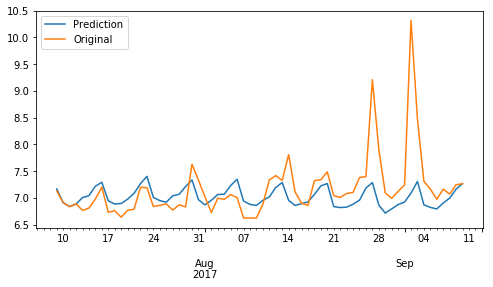

In [170]:
merged.plot(kind='line',figsize=(8,4))
# plt.ylim(top=100)  # adjust the top leaving bottom unchanged
# plt.ylim(bottom=0)

In [114]:
prior_mat_df=pd.DataFrame(prior_mat,columns=date_Cols_mine_)
prior_mat_df['page_id'] = pages_mat
page_id_df = pd.read_csv('data/processed/page_ids.csv', encoding='utf-8')

In [102]:
keys = pd.read_csv('key_2.csv', encoding='utf-8')
keys['date'] = keys.Page.apply(lambda a: a[-10:])
keys['Page'] = keys.Page.apply(lambda a: a[:-11])
keys['date'] = keys['date'].astype('datetime64[ns]')

pred_df = pred_df.merge(keys, how='left', on=['Page', 'date'])
pred_df['Visits'] = pred_df['Visits'].map(np.round).astype(int)
pred_df = pred_df[['Id', 'Visits']].sort_values(by='Id')
pred_df.to_csv('sub.csv', encoding='utf-8', index=False)

In [103]:
pred_df

,Id,Visits
3506745,0000009abb1c,82
2503749,0000023b7434,8
3483216,000002ddbe6e,102
7644955,0000032f82ac,940
3198053,000003e266a3,45
2592832,000005c4dae8,6
2459417,00000739df42,44
3414090,0000074046ad,18
2124271,00000afca055,376
6486511,00000afd6648,71
